# 損失規避策略：守護本金的守衛

投資股票時，適當的設立止損點有助於投資人的資金在空頭走勢或高波動的環境下不至於快速流失，  
真實波動幅度均值（Average True Range，ATR）衡量資產價格波動性的特性，就成為我們設立止損點的重要工具！ 

本範例將以「布林通道 + ATR 指標」作為損失規避策略的實驗組；以一般常見之「布林通道」策略作為對照組，  
觀察利用損失規避策略的實驗組能否幫助投資人有效規避風險，甚至獲得較優異的績效表現。

本範例包含以下六大部分：   

    一、 設定基本環境 & 導入股價資料  
    二、 計算布林通道上、中、下軌 & ATR  
    三、 設定回測參數  
    四、 建構布林通道 + ATR 損失規避策略  
    五、 執行交易策略  
    六、 風險績效視覺化  

## 一、 設定基本環境 & 導入股價資料

導入股價資料前，我們要先使用 `os` 設定環境變數，
``` python
os.environ['TEJAPI_KEY'] = tej_key        ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base      ==> 導航至 tej api 網域。
os.environ['mdate'] = start + ' ' + end   ==> 設定資料時間範圍。
os.environ['ticker'] = '1413'             ==> 設定導入'1413'的股價資料。
```

In [1]:
import os
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set tej_key and base
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

# set date
start = '2023-01-01'
end = '2023-12-31'
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = '1413'

`!zipline ingest` 可將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tqant
```

In [2]:
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 1018/100000 (1.02%)
Currently used TEJ API key data quota 8902473/10000000 (89.02%)


[2024-05-28 09:18:50.073835] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-28 09:18:51.352898] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 二、 計算布林通道上、中、下軌 & ATR

導入 `Pipeline()` 函式，於本範例我們用以處理：  
1. 利用客製化因子的函式計算 ATR ( 客製化因子函式的詳細操作方式可參考：[Custom Factors](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Custom%20Factors.ipynb) )
2. 利用 `Pipeline()` 內建的因子庫計算布林通道上、中、下軌 ( 以 20 日為計算窗格 )

註： ATR的計算基於「真實波動幅度」（True Range）。真實波幅代表特定時間內的最大價格變動範圍，通常由以下三個差值中的最大值來確定：

1. 當日最高價與最低價之差
2. 前日收盤價與當日最高價之差
3. 前日收盤價與當日最低價之差

計算 ATR 的一般步驟如下：  
1. 計算「真實波動幅度」（True Range，TR）
2. 對 TR 取移動平均數，得到 ATR




In [3]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.data import EquityPricing, TWEquityPricing
from zipline.pipeline.factors import BollingerBands, TrueRange, CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack

start_time = pd.Timestamp(start, tz = 'UTC')
end_time = pd.Timestamp(end,tz = 'UTC')
bundle = bundles.load('tquant')

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )
    
    window_length = 20

    outputs = ["TR", "SMA_ATR"]
    
    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis = 0)
        
        out.TR = tr_current[-1]
        out.SMA_ATR = sma_atr_values

def make_pipeline():
    
    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                     TWEquityPricing.low,
                                     TWEquityPricing.close])

    perf = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=2)
    upper,middle,lower = perf.upper, perf.middle, perf.lower
    curr_price = EquityPricing.close.latest
    
    return Pipeline(
        columns = {
            'SMA_ATR': ATR.SMA_ATR,
            'upper': upper,
            'middle': middle,
            'lower': lower,
            'curr_price': curr_price
        },
    )

pipeline_result = run_pipeline(make_pipeline(), start_time, end_time)
pipeline_result 

,,SMA_ATR,upper,middle,lower,curr_price
2023-01-04 00:00:00+00:00,Equity(0 [1413]),NaN,9.540000,9.540000,9.540000,9.54
2023-01-05 00:00:00+00:00,Equity(0 [1413]),NaN,9.550000,9.530000,9.510000,9.52
2023-01-06 00:00:00+00:00,Equity(0 [1413]),NaN,9.598320,9.493333,9.388347,9.42
2023-01-09 00:00:00+00:00,Equity(0 [1413]),NaN,9.591655,9.470000,9.348345,9.40
2023-01-10 00:00:00+00:00,Equity(0 [1413]),NaN,9.581105,9.472000,9.362895,9.48
...,...,...,...,...,...,...
2023-12-25 00:00:00+00:00,Equity(0 [1413]),0.118947,8.499149,8.285000,8.070851,8.46
2023-12-26 00:00:00+00:00,Equity(0 [1413]),0.115789,8.498428,8.302000,8.105572,8.41
2023-12-27 00:00:00+00:00,Equity(0 [1413]),0.101053,8.513156,8.318500,8.123844,8.47
2023-12-28 00:00:00+00:00,Equity(0 [1413]),0.097895,8.521259,8.322000,8.122741,8.42


## 三、 設定回測參數

導入 `initialize()` 函式。`initialize()` 用於定義回測參數，並可自訂變數來紀錄交易訊息，於此例中我們設置：
1. 流動性滑價
2. 交易手續費
3. 買入持有宏洲 ( 1413 ) 的報酬作為基準
4. 將 Pipeline 導入交易流程中
5. 設定 context.last_buy_price 來記錄前一次交易的價格
6. 設定 context.stop_loss 記錄停損點價位






In [4]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=0.25, price_impact=0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('1413'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_buy_price = 0
    context.stop_loss = 0

## 四、 建構布林通道 + ATR 損失規避策略

導入 `handle_data()` 函式。`handle_data()` 為構建交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
  
於本範例我們建立以下的交易規則：
 - 若當日收盤價跌破布林下軌且現金水位足夠時，於隔日買入1000股。
 - 若當日收盤價突破布林上軌且持有部位時，於隔日出清部位。
 - 若當日收盤價跌破布林下軌、現金水位足夠，且當日收盤價未跌破停損點，隔日加碼1000股。
 - 若當日收盤價跌破停損點且持有部位時，於隔日出清部位。

註： 停損點計算 = 買入價格 – k × ATR ( k 值依股價波動度而定，若波動度較大，可設定較大的k值，反之亦然。本範例設定 **k = 0.1** )

In [5]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')  # 取得每天 pipeline 的布林通道上中下軌 & ATR

    for i in out_dir.index: 
        curr_price = out_dir.loc[i, 'curr_price']
        upper = out_dir.loc[i, 'upper']
        lower = out_dir.loc[i, 'lower']
        atr = out_dir.loc[i, 'SMA_ATR']
        
        cash_position = context.portfolio.cash  # 記錄現金水位
        stock_position = context.portfolio.positions[i].amount  # 記錄股票部位

        loss_stopped, buy, sell = False, False, False
        record(price = curr_price, upper = upper, lower = lower, stop_loss = context.stop_loss, buy = buy, sell = sell, loss_stopped = loss_stopped)
        
        # 收盤價 > 止損價的狀況：
        if (curr_price > context.stop_loss) or (context.last_buy_price == 0):
            
            # 若收盤價 <= 布林下軌，則買入或加碼
            if (curr_price <= lower) and (cash_position > curr_price * 1000):
                order(i, 1000)
                buy = True
                record(buy = buy)
                context.stop_loss = curr_price - (0.1 * atr)
                
            # 若收盤價 >= 布林上軌，則出清部位
            elif (curr_price >= upper) and (stock_position > 0):
                order_target(i, 0)
                sell = True
                record(sell = sell)

        # 若收盤價 <= 停損價，則出清部位
        if (curr_price <= context.stop_loss) and (stock_position > 0):
            order_target(i, 0)
            sell = True
            loss_stopped = True
            record(sell = sell, loss_stopped = loss_stopped)

## 五、 執行交易策略

***Step 1***:  

導入 `analyze()` 函式。`analyze()` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值表並畫出宏洲股價走勢、布林上下軌以及買賣時機點。

In [6]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax = ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Stock Price (NTD)")
    perf.price.plot(ax = ax2)
    perf.upper.plot(ax = ax2)
    perf.lower.plot(ax = ax2)
    
    buy_status, sell_status = perf.buy, perf.sell
    buy_status.fillna(False, inplace = True)
    sell_status.fillna(False, inplace = True)
    
    ax2.plot( # 繪製買入訊號
        perf.index[perf.buy],
        perf.loc[perf.buy, 'price'],
        '^',
        markersize = 5,
        color = 'red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.sell],
        perf.loc[perf.sell, 'price'],
        'v',
        markersize = 5,
        color = 'green'
    )
    
    plt.legend(loc = 0)
    plt.gcf().set_size_inches(18,8)
    plt.show()

***Step 2:***  
  
使用 `run_algorithm()` 執行上述設定的交易策略，設置交易期間為 *start_time* ( 2023-01-01 ) 到 *end_time* ( 2023-12-31 )，所使用資料集為 *tquant*，初始資金為 100,000 元。其中輸出的 *results* 就是每日績效與交易的明細表。

因本範例利用實驗組 ( 損失規避策略： 布林通道 + ATR ) 與對照組 ( 僅布林通道 ) 來觀察設定止損點的效果，因此以下將分別呈現兩個組別的結果，以利我們進行止損效果的分析。


### 損失規避策略投組價值 & 買賣時機圖表

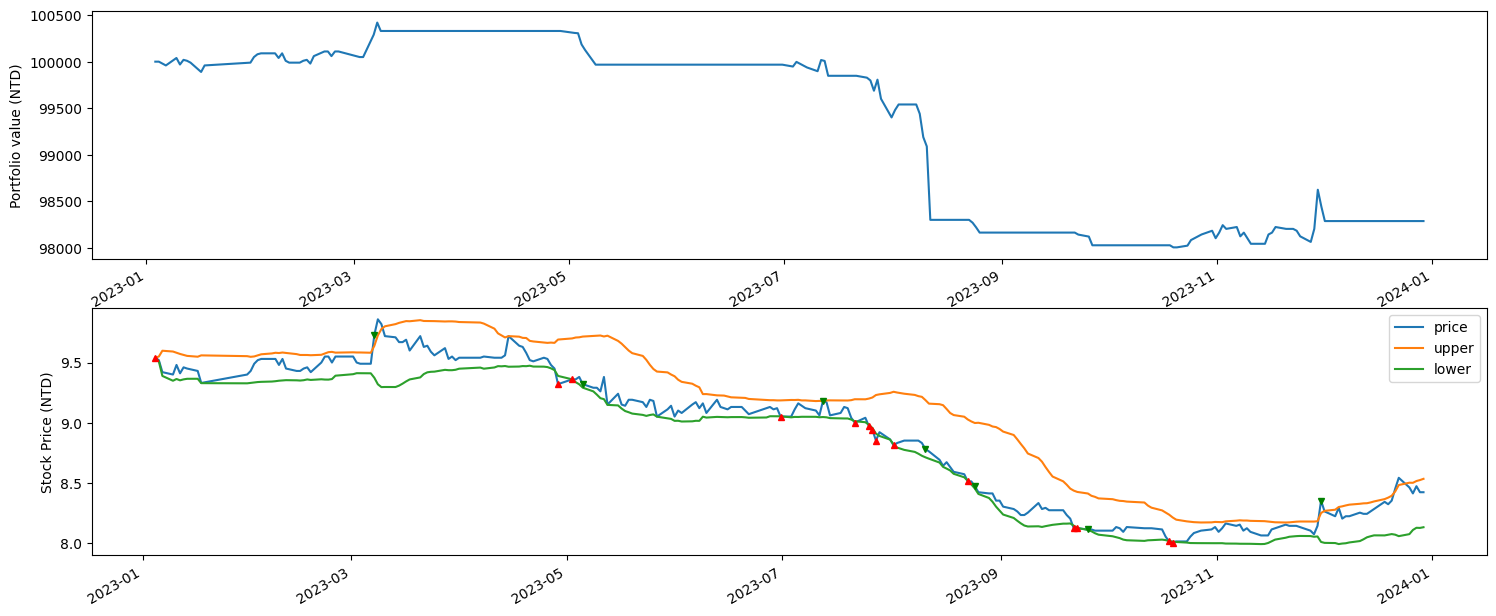

,period_open,period_close,short_value,long_exposure,orders,ending_exposure,short_exposure,transactions,gross_leverage,benchmark_return,...,algo_volatility,period_label,algorithm_period_return,price,upper,lower,stop_loss,buy,sell,loss_stopped
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,0.0,0.0,[],0.0,0.0,[],0.000000,0.010593,...,NaN,2023-01,0.000000,NaN,NaN,NaN,NaN,False,False,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,0.0,0.0,"[{'id': 'b1be00afebfe4dc79834cdfe86ee62c4', 'd...",0.0,0.0,[],0.000000,-0.002096,...,0.000000,2023-01,0.000000,9.54,9.540000,9.540000,0.000000,True,False,False
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,0.0,9420.0,"[{'id': 'b1be00afebfe4dc79834cdfe86ee62c4', 'd...",9420.0,0.0,"[{'amount': 1000, 'dt': 2023-01-05 13:30:00+08...",0.094219,-0.010504,...,0.001890,2023-01,-0.000206,9.52,9.550000,9.510000,NaN,False,False,False
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,0.0,9400.0,[],9400.0,0.0,[],0.094038,-0.002123,...,0.001862,2023-01,-0.000406,9.42,9.598320,9.388347,NaN,False,False,False
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,0.0,9480.0,[],9480.0,0.0,[],0.094763,0.008511,...,0.006603,2023-01,0.000394,9.40,9.591655,9.348345,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,0.0,0.0,[],0.0,0.0,[],0.000000,-0.005910,...,0.012316,2023-12,-0.017110,8.46,8.499149,8.070851,7.991579,False,False,False
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,0.0,0.0,[],0.0,0.0,[],0.000000,0.007134,...,0.012290,2023-12,-0.017110,8.41,8.498428,8.105572,7.991579,False,False,False
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,0.0,0.0,[],0.0,0.0,[],0.000000,-0.005903,...,0.012264,2023-12,-0.017110,8.47,8.513156,8.123844,7.991579,False,False,False
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,0.0,0.0,[],0.0,0.0,[],0.000000,0.000000,...,0.012239,2023-12,-0.017110,8.42,8.521259,8.122741,7.991579,False,False,False


In [7]:
from zipline import run_algorithm

results = run_algorithm(
    start = start_time,
    end = end_time,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e5,
    handle_data = handle_data
)

results

### 對照組 ( 僅布林通道 ) 投組價值 & 買賣時機圖表

![對照組results](https://github.com/tejtw/TEJAPI_Python_Medium_Quant/blob/main/Elements/1413_portfolio_%E5%B0%8D%E7%85%A7.png?raw=true)

## 六、 風險績效視覺化

TQuant Lab 的 `Pyfolio` 套件可快速幫我們生成各式各樣的風險績效圖表。

In [8]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

### 損失規避策略夏普比率圖

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

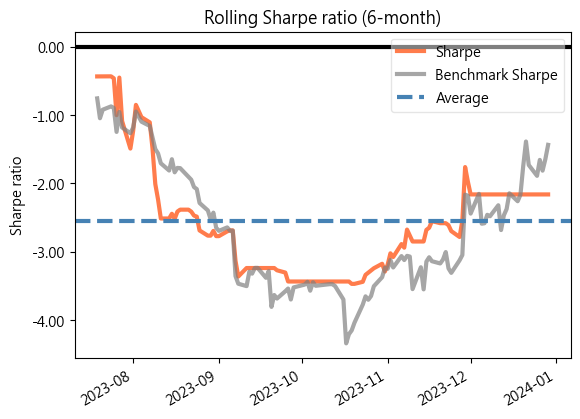

In [9]:
from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns = benchmark_rets
                       )

### 對照組 ( 僅布林通道 ) 夏普比率圖

![對照組 Sharpe](https://github.com/tejtw/TEJAPI_Python_Medium_Quant/blob/main/Elements/1413_sharpe_%E5%B0%8D%E7%85%A7.png?raw=true)

### 損失規避策略前 5 大交易回撤期間

In [ ]:
from pyfolio.plotting import plot_drawdown_periods
plot_drawdown_periods(returns, top = 5)

![實驗組 drawdown](https://github.com/tejtw/TEJAPI_Python_Medium_Quant/blob/main/Elements/1413_drawdown_%E5%AF%A6%E9%A9%97.png?raw=true)

### 對照組 ( 僅布林通道 ) 前 5 大交易回撤期間

![對照組 drawdown](https://github.com/tejtw/TEJAPI_Python_Medium_Quant/blob/main/Elements/1413_drawdown_%E5%B0%8D%E7%85%A7.png?raw=true)

### 損失規避策略 & 宏洲買進持有報酬率比較圖

<AxesSubplot:ylabel='Cumulative returns'>

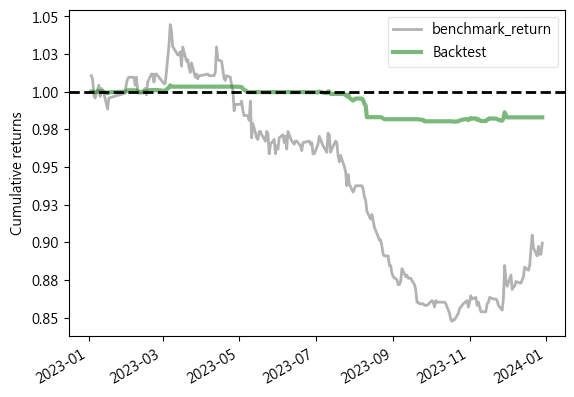

In [11]:
from pyfolio.plotting import plot_rolling_returns
plot_rolling_returns(returns, factor_returns = benchmark_rets)

### 損失規避策略 & 宏洲買進持有波動率比較圖

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

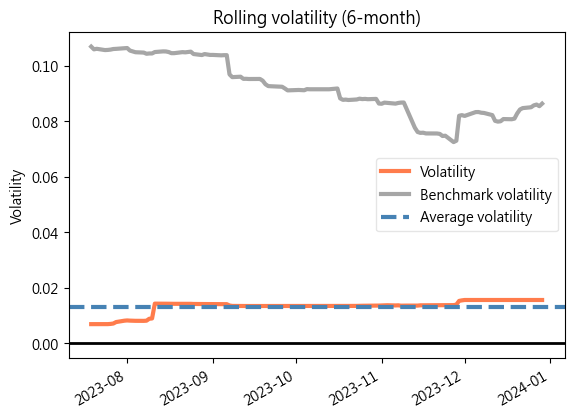

In [12]:
from pyfolio.plotting import plot_rolling_volatility
plot_rolling_volatility(returns,
                        factor_returns = benchmark_rets)

### 損失規避策略交易績效簡表

In [13]:
performance = pf.plotting.show_perf_stats(
              returns,
              benchmark_rets,
              positions = positions,
              transactions = transactions)

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,-1.803%
Cumulative returns,-1.711%
Annual volatility,1.221%
Sharpe ratio,-1.48
Calmar ratio,-0.75
Stability,0.77
Max drawdown,-2.403%


### 繪製所有 `Pyfolio` 提供的績效風險圖表

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,-1.803%
Cumulative returns,-1.711%
Annual volatility,1.221%
Sharpe ratio,-1.48
Calmar ratio,-0.75
Stability,0.77
Max drawdown,-2.403%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.40,2023-03-07,2023-10-19,NaT,NaN
1,0.15,2023-01-09,2023-01-16,2023-01-31,9
2,0.11,2023-02-08,2023-02-16,2023-02-20,9
3,0.06,2023-02-24,2023-03-02,2023-03-06,5
4,0.05,2023-02-06,2023-02-07,2023-02-08,3


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,-0.01%,-0.80%,0.43%


Top 10 long positions of all time,max
sid,
1413,44.45%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1413,44.45%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

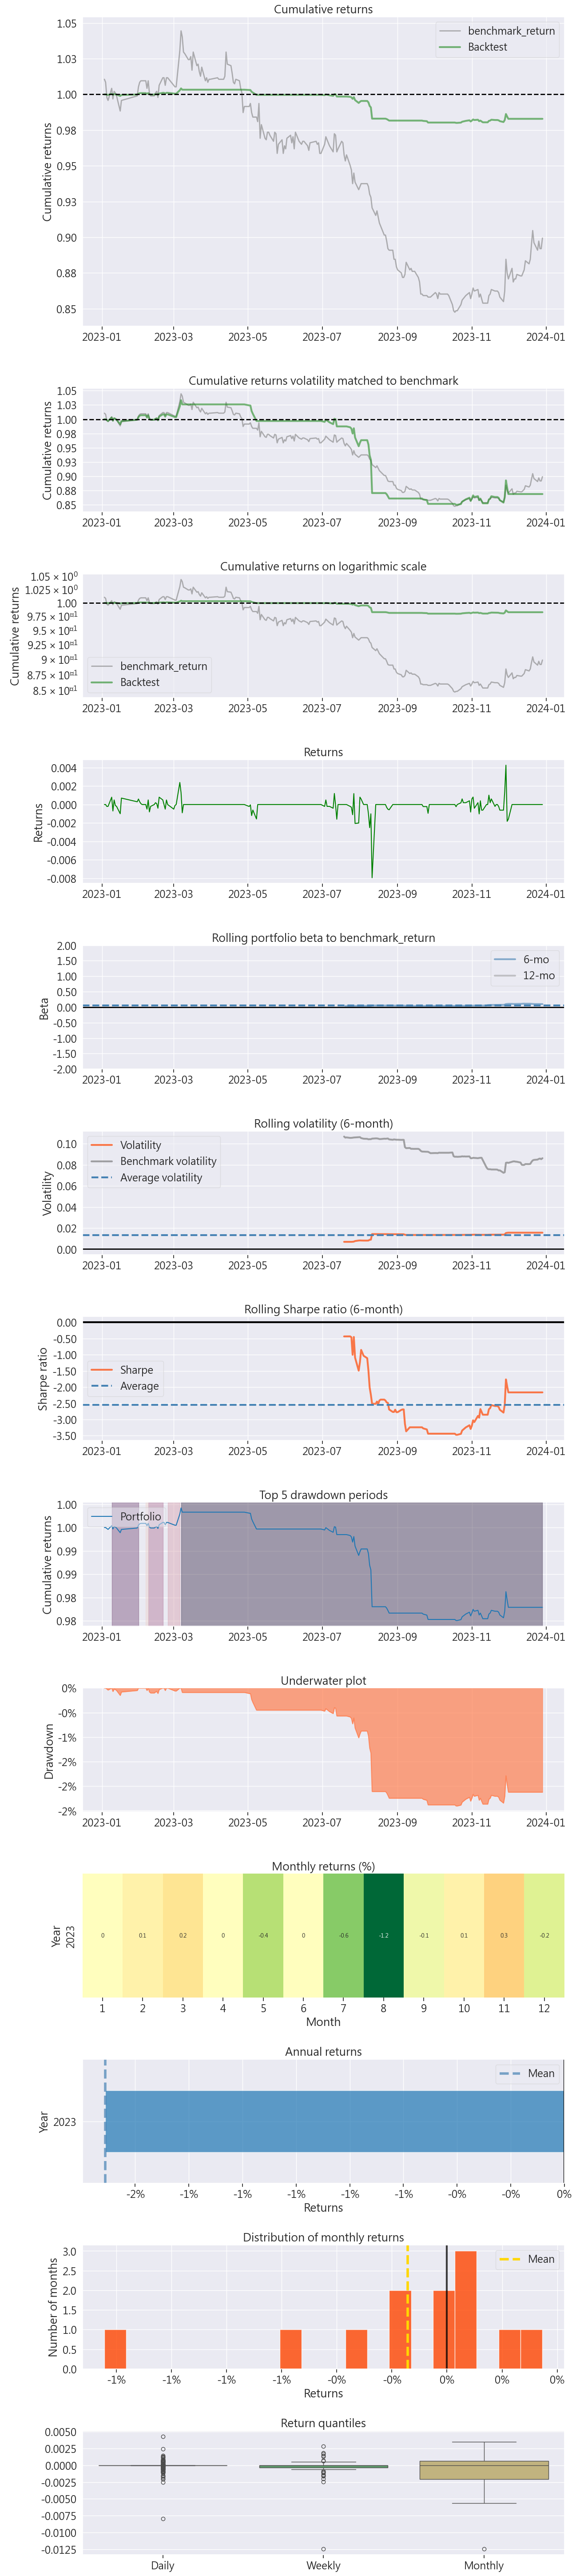

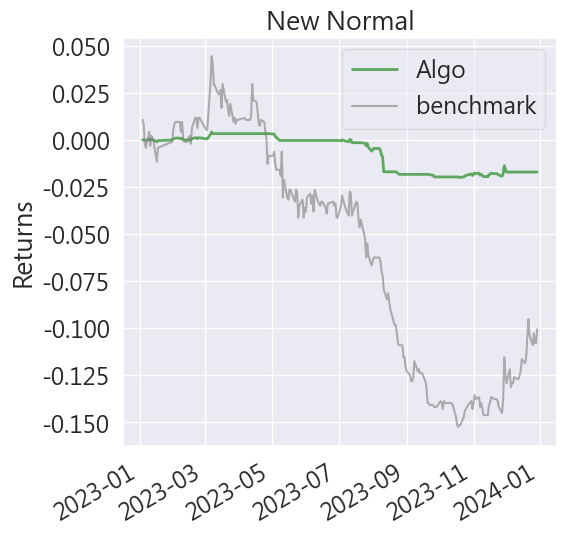

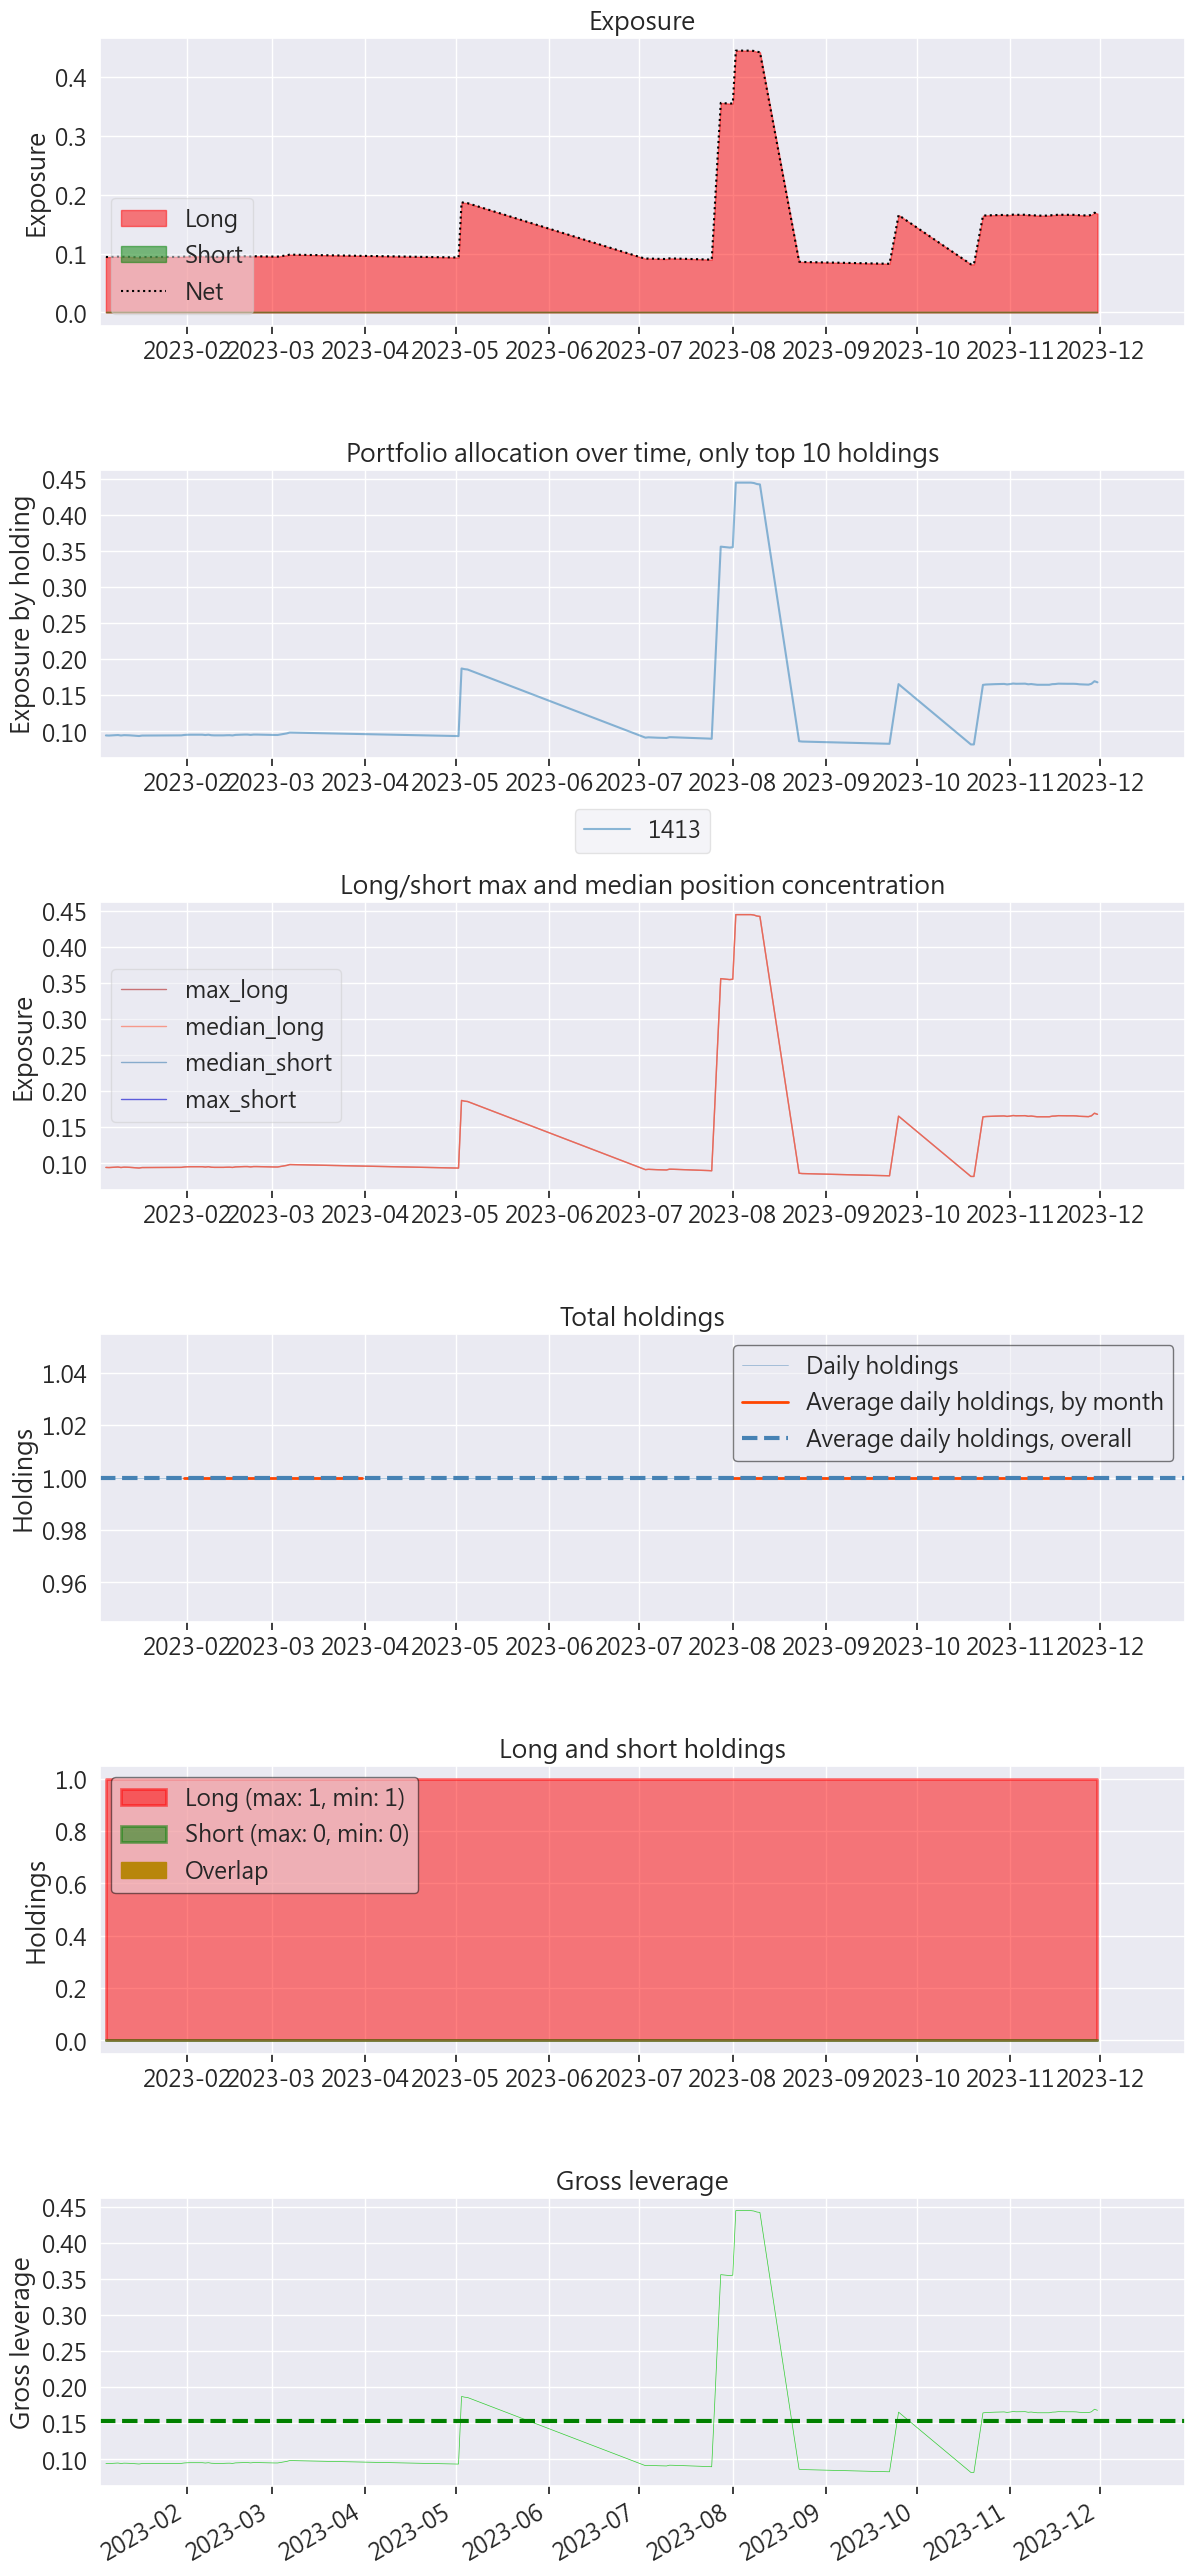

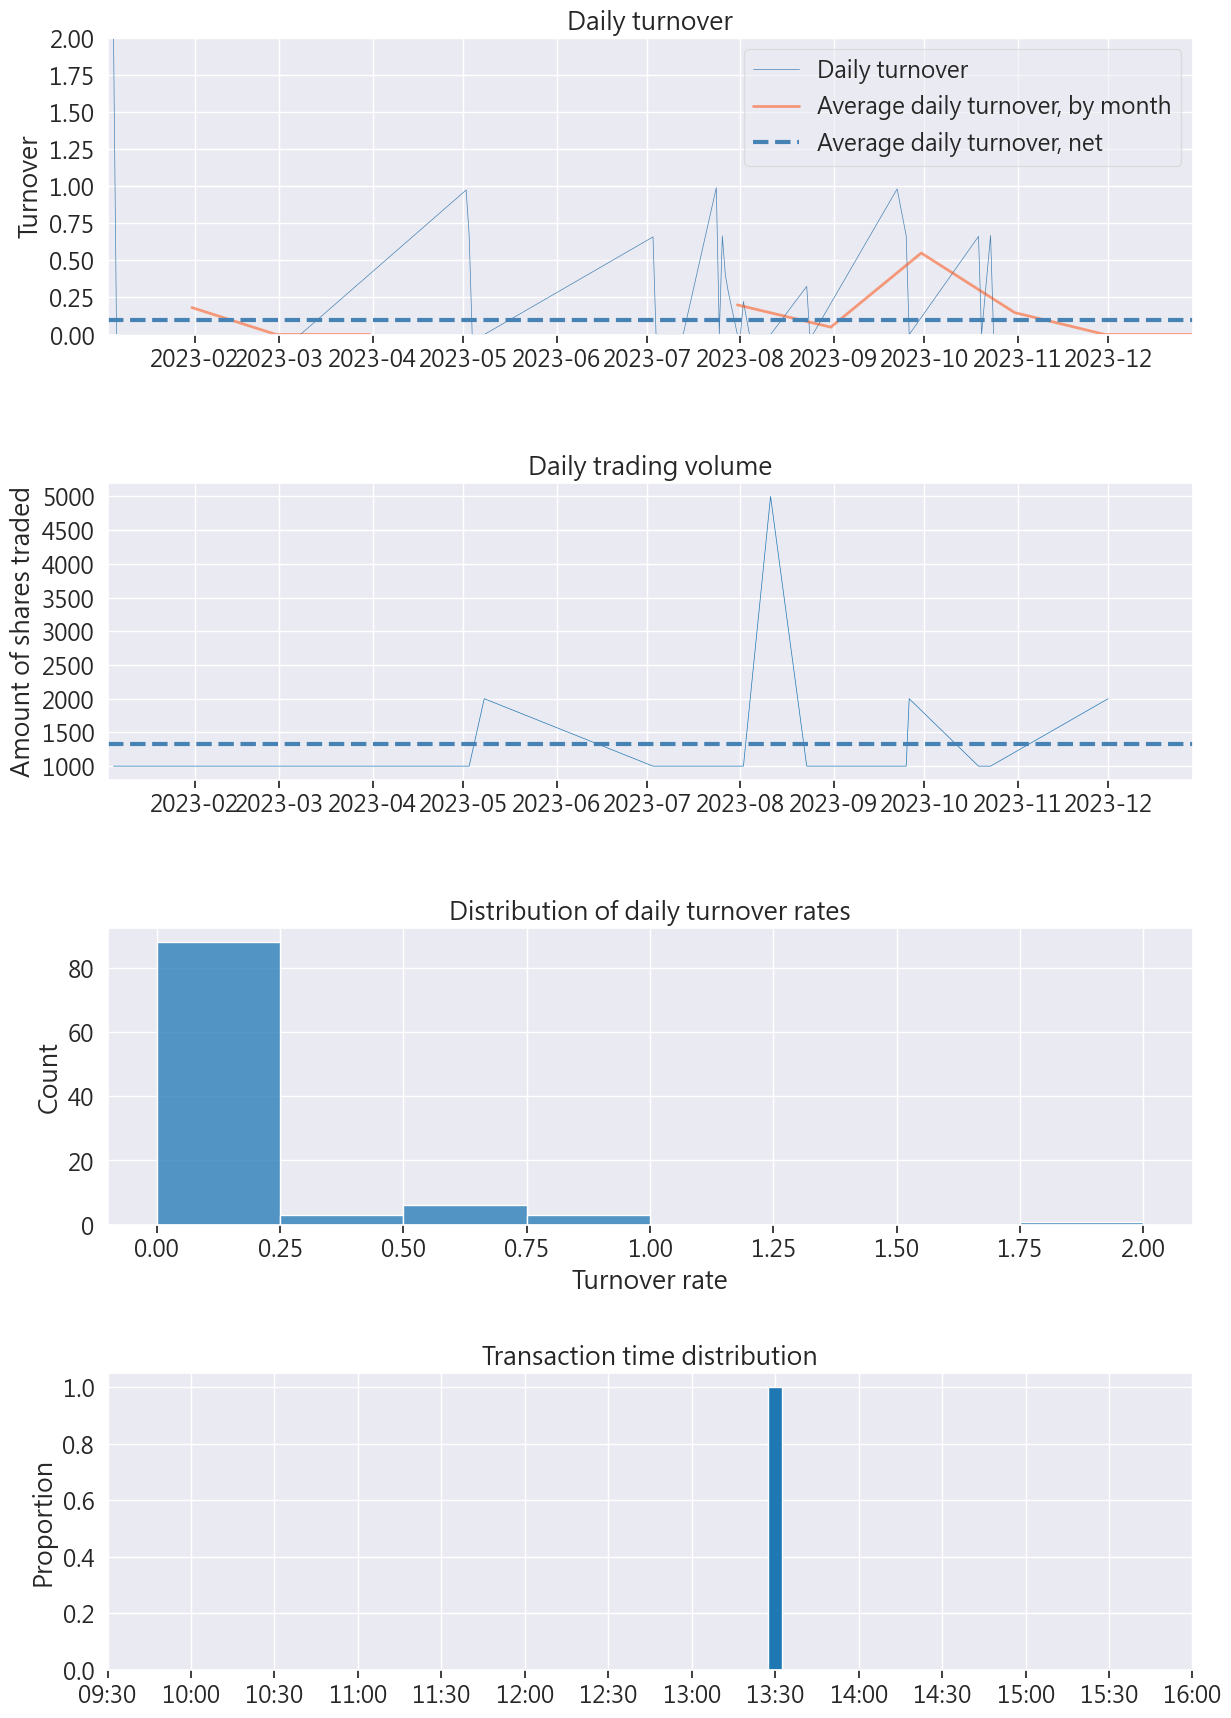

In [14]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )